In [1]:
# mol_reduction
# a program to test out reductions on the size of molecules

In [2]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType

# classical optimizer for updating ansatz
from qiskit.aqua.components.optimizers import SLSQP

# Initial ansatz that we optimize over vqe
from qiskit.chemistry.components.initial_states import HartreeFock

# varies HF guess into vqe ansatz
# converts initial guess into ansatz
from qiskit.chemistry.components.variational_forms import UCCSD

# helps set up the molecule
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.aqua.operators import Z2Symmetries, WeightedPauliOperator

# from qiskit.chemistry.core import Hamiltonian, QubitMappingType

/home/jay/.local/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)
/home/jay/.local/lib/python3.6/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [3]:
## build molecule and set up
# current example is C2
molecule = 'C .0 .0 -{0}; C .0 .0 {0}'

## distances
# calculate structure of molecule at different interatomic distances
# distances = np.arange(0.5, 4.25, 0.25)
distances = np.arange(1.5, 2.25, 3.0)


## arrays to hold the energy results
vqe_energies = []
hf_energies = []
exact_energies = []

In [5]:
for i, d in enumerate(distances):

    ## set up experiment
    # the driver first represents the molecular problem
    driver = PySCFDriver(molecule.format(d/2), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')

    ## transform the molecular problem into a qubit problem
    # FermionicTransformation takes the following arguments:
    #   qubit_mapping
    #   two_qubit_reduction - this can be used with parity mapping type to further reduce qubits
    #   freeze_core - replace core electrons with one calculation
    #   orbital_reduction 
    #       - list of numbered molecular orbitals to remove from the problem
    #       - for each molecular orbital removed here, 2 spin orbitals/qubits will be removed
    #   z2symmetry_reduction - can be set to None or 'auto', as well as set manually    
    operator = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.PARITY,
            two_qubit_reduction=True, freeze_core=True,
            orbital_reduction=[-3,-2,-1], z2symmetry_reduction=None)
   
    # complete transformation
    qubit_op, aux_ops = operator.transform(driver)

    print("+++ Part 1 +++")

    print("Molecule info= ", operator.molecule_info)
    print("# of qubits= ",qubit_op.num_qubits)

    
    print("+++ Part 2 +++")
    
    # vqe
    optimizer = SLSQP(maxiter=50)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                        operator.molecule_info['num_particles'],
                        qubit_mapping=operator._qubit_mapping,
                        two_qubit_reduction=operator._two_qubit_reduction)
    
    # var form - how we take the init state and do the variations
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    
    print("+++ Part 2a +++")
    
    # algorithm
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    print("+++ Part 2b +++")

    # plug into and run
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    # print(vqe_result)
    vqe_result = operator.interpret(vqe_result)
    
    print("+++ Part 3 +++")
    print(vqe_result)

    vqe_energies.append(vqe_result.total_energies)

    hf_energies.append(vqe_result.hartree_fock_energy)

+++ Part 1 +++
Molecule info=  {'num_particles': (4, 4), 'num_orbitals': 10, 'two_qubit_reduction': True, 'z2_symmetries': <qiskit.aqua.operators.legacy.weighted_pauli_operator.Z2Symmetries object at 0x7fb08706d240>}
# of qubits=  8
+++ Part 2 +++
/home/jay/.local/lib/python3.6/site-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()
+++ Part 2a +++
+++ Part 2b +++
/home/jay/.local/lib/python3.6/site-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/home/jay/.local/lib/python3.6/site-packages/qiskit/chemistry/comp

In [6]:
print(vqe_result.total_energies)
print(vqe_result.hartree_fock_energy)

[-74.43683691]
-74.33569992878756


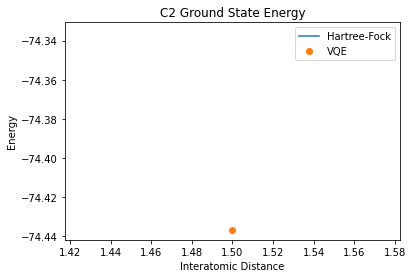

In [7]:
# plot
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')

pylab.xlabel('Interatomic Distance')
pylab.ylabel('Energy')
pylab.title('C2 Ground State Energy')
pylab.legend(loc='upper right')